In [1]:
%matplotlib inline

import copy
import matplotlib.pyplot as pyplot

import numpy as np

import geopandas as gpd
import shapely.geometry as geom
import shapely.affinity as affine

from weavingspace import Topology
from weavingspace import TileShape
from weavingspace import TileUnit
from weavingspace import WeaveUnit
from weavingspace import tiling_utils

In [2]:
square = tiling_utils.get_regular_polygon(200, 4)
L_shape = square.union(
  affine.translate(square, 200, 0)).union(
  affine.translate(square, 0, 200))
L_shape = tiling_utils.get_clean_polygon(L_shape)

tile = TileUnit()
tile.base_shape = TileShape.HEXAGON
tile.tiles = gpd.GeoDataFrame(
  {"tile_id": list("abcd")},
  geometry = gpd.GeoSeries([affine.translate(L_shape, -100, 200), 
                            affine.translate(L_shape, 100, -200),
                            affine.translate(L_shape, -100, -400), 
                            affine.translate(L_shape, -300, 0)]))
tile.setup_regularised_prototile_from_tiles()
tile.prototile = gpd.GeoDataFrame(
  geometry = gpd.GeoSeries(
    geom.Polygon([(100, -450), (-300, -350), (-300, 350),
                  (-100, 450), (300, 350), (300, -350)])))
tile.setup_vectors()

/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


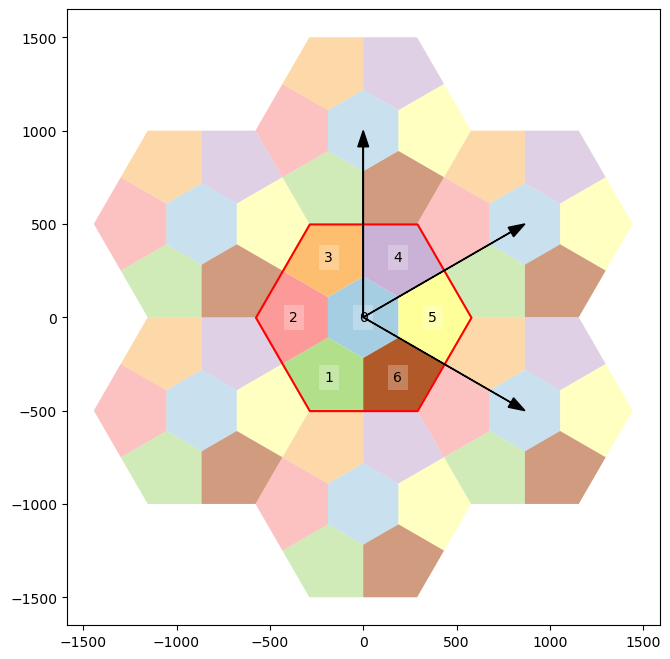

In [3]:
tile = TileUnit(tiling_type = "archimedean", code = "3.3.4.3.4")
tile = TileUnit(tiling_type = "hex-dissection", n = 7, offset = 1)
# tile = TileUnit(tiling_type = "hex-slice", n = 3, offset = 1)
# tile = TileUnit(tiling_type = "archimedean", code = "3.4.6.4")
# tile = TileUnit(tiling_type = "archimedean", code = "3.12.12")
# tile = TileUnit(tiling_type = "archimedean", code = "4.8.8")
# tile = TileUnit(tiling_type = "cairo", n = 3)
# tile = TileUnit(tiling_type = "hex-colouring", n = 3).transform_skew(20).transform_scale(1.2)
# tile = WeaveUnit(weave_type = "plain", n = 2, strands = "a|d")
# tile = WeaveUnit(weave_type = "basket", n = 3, strands = "abc|def", spacing = 200)
# tile = WeaveUnit(weave_type = "twill", n = 2, strands = "ab|de")
ax = tile.plot(r = 1, show_reg_prototile = True, show_prototile = True, cmap = "Paired", show_ids = "id", r_alpha = 0.6, show_vectors = True)

In [4]:
topo = Topology(tile)

/Users/osullid3/miniconda3/envs/weaving/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


## Plot of topology
Various options - but showing below the vertex and edge labelling resulting from determination of transitivity classes, and with tiles coloured by transitivity class.

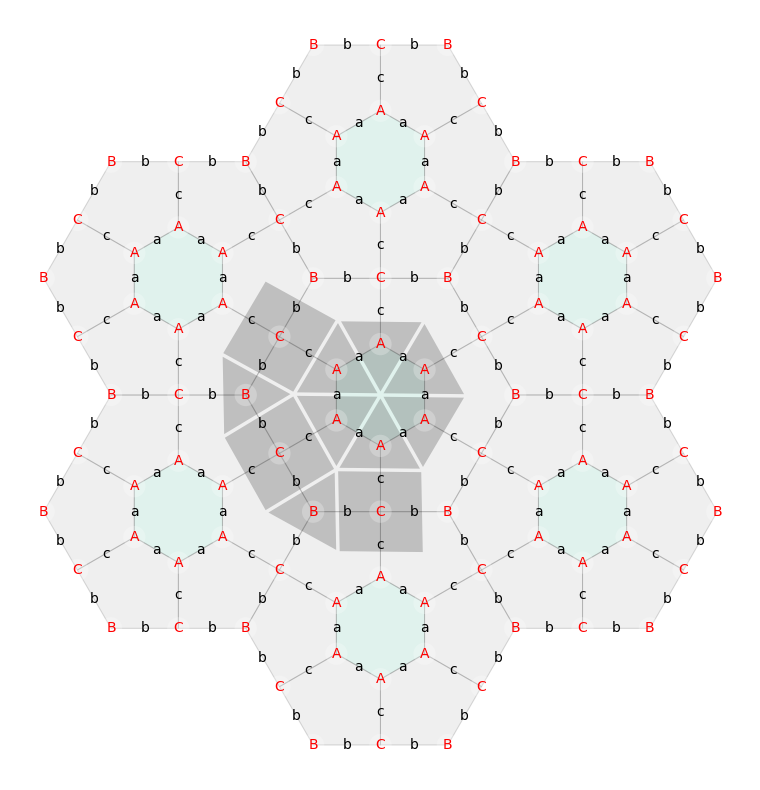

In [5]:
ax = topo.plot(
  show_original_tiles = True,
  show_tile_vertex_labels = False,
  show_tile_edge_labels = False,
  show_tile_centres = False,
  show_vertex_labels = True,
  show_vertex_ids = False,
  show_edge_labels = True,
  show_edges = False,
  offset_edges = False,
  show_dual_tiles = True
)
# gpd.GeoSeries(symmetry_centres).plot(ax = ax)

## Tiling symmetries
As discovered in topology construction.

In [6]:
topo.tile_matching_transforms

{0: reflection 60.0° POINT (-0.0 -0.0) (-0.5, 0.866, 0.866, 0.5, 0.0, 0.0),
 1: reflection 30.0° POINT (-0.0 -0.0) (0.5, 0.866, 0.866, -0.5, 0.0, 0.0),
 2: reflection 0.0° POINT (-0.0 -0.0) (1.0, 0.0, 0.0, -1.0, 0.0, 0.0),
 3: reflection -30.0° POINT (-0.0 -0.0) (0.5, -0.866, -0.866, -0.5, 0.0, 0.0),
 4: reflection -60.0° POINT (-0.0 -0.0) (-0.5, -0.866, -0.866, 0.5, 0.0, 0.0),
 5: reflection -90.0° POINT (-0.0 -0.0) (-1.0, -0.0, -0.0, 1.0, 0.0, 0.0),
 25: rotation 60.0° POINT (-0.0 -0.0) (0.5, -0.866, 0.866, 0.5, 0, 0),
 27: rotation 120.0° POINT (-0.0 0.0) (-0.5, -0.866, 0.866, -0.5, 0, 0),
 29: rotation 180.0° POINT (0.0 0.0) (-1.0, -0.0, 0.0, -1.0, 0, 0),
 31: rotation -120.0° POINT (0.0 -0.0) (-0.5, 0.866, -0.866, -0.5, 0, 0),
 33: rotation -60.0° POINT (0.0 0.0) (0.5, 0.866, -0.866, 0.5, 0, 0)}

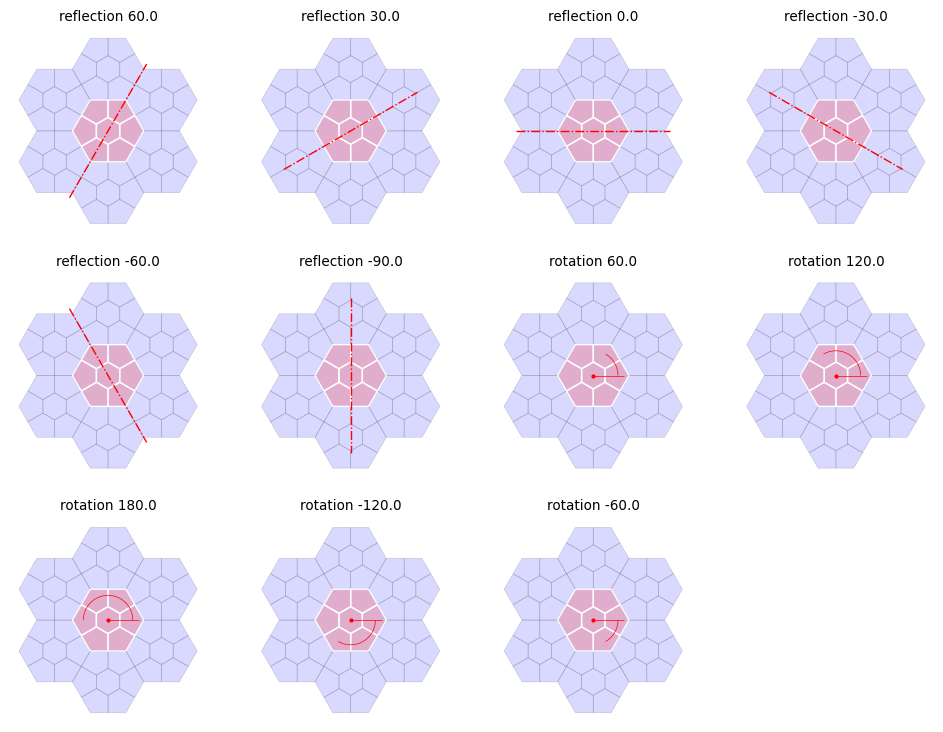

In [7]:
topo.plot_tiling_symmetries(mirror_length = 2500, radius = 400, c = geom.Point(0, 0), )

## Dual tiling from the topology

(-2641.9774218, 2329.0427598, -2939.5065628999996, 2754.8337788999997)

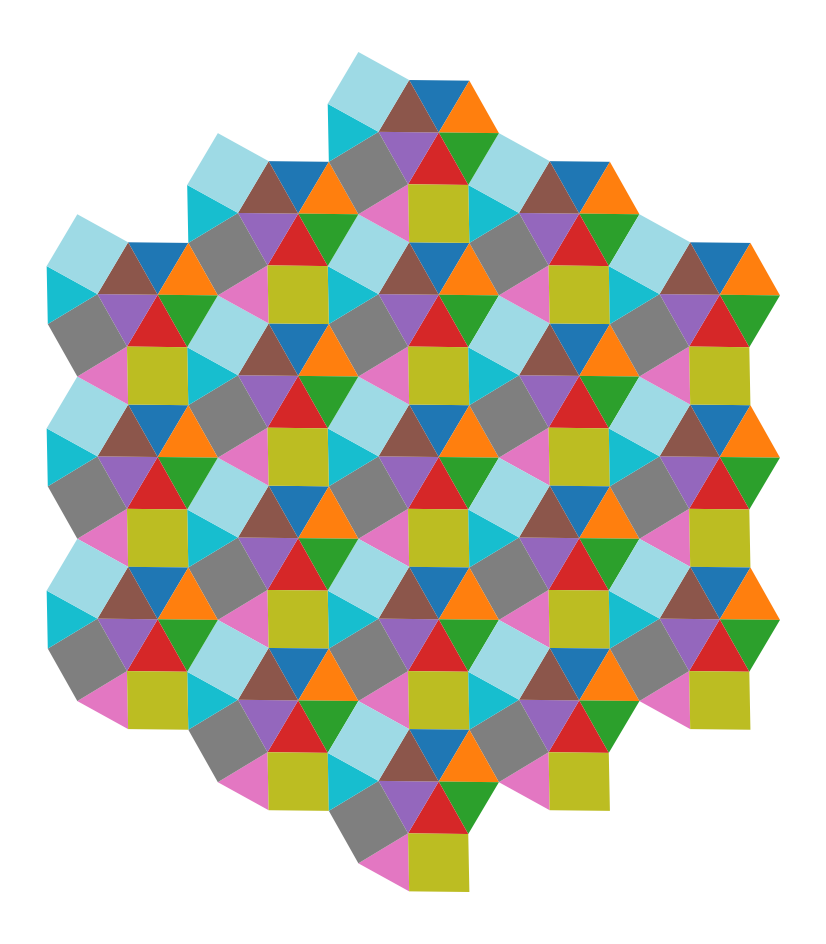

In [8]:
tile2 = copy.deepcopy(topo.tileable)
dual_tiles = list(topo.dual_tiles.values())
tile2.tiles = gpd.GeoDataFrame(
  data = {"tile_id": list("abcdefghijklmnopqrstuvwxyz")[:len(dual_tiles)]},
  geometry = gpd.GeoSeries(dual_tiles))
tile2.setup_regularised_prototile_from_tiles()
ax = tile2.plot(r = 2, show_reg_prototile = False, show_prototile = False,
           cmap = "tab20", r_alpha = 1, show_ids = False, figsize = (12, 12))
pyplot.axis("off")